# Game of Life - Part 2

*Author*: **qpxu007@gmail.com**

## Putting it together

In part 1, we explored ways to implement the Game of Life in different boundary conditions. 
We showed that it is more elegant to represent the data as list of tuples, which are positions of all live cells. 
Here we encapsulate the implementation in a class.    

In [27]:
import numpy as np


class GameOfLife(object):
    def get_xylim(self):
        """ Given positions of cells, find the minimum rectangle to
        cover those cells, represented by [(xmin,ymin), (xmax, ymax)]
        """

        # assume random ordering of tuples, otherwise, sort by y is not needed
        tuples_sorty = sorted(self.data, key=lambda x: x[1])
        ymin = tuples_sorty[0][1]
        ymax = tuples_sorty[-1][1]

        tuples_sortx = sorted(self.data, key=lambda x: x[0])
        xmin = tuples_sortx[0][0]
        xmax = tuples_sortx[-1][0]
        return [(xmin, xmax), (ymin, ymax)]

    def __mat2tuples(self, matrix):
        """ Given cells represented in a matrix, return a list of
        positions (i,j) with live cells"""

        return [(i, j) for i, row in enumerate(matrix)
                for j, col in enumerate(row) if col]

    def __tuples2minmat(self):
        """ Given positions of live cells (as x,y tuples), convert them in a
        minimum matrix representation"""
        if not self.data:
            return [[]], 0, 0

        (xmin, xmax), (ymin, ymax) = self.get_xylim()
        ny = ymax - ymin + 1
        nx = xmax - xmin + 1
        matrix = [[0] * ny for _ in range(nx)]
        for t in self.data:
            x = t[0] - xmin
            y = t[1] - ymin
            matrix[x][y] = 1

        return matrix, xmin, ymin

    def __init__(self, data=None, m=5, n=5, seed=1,
                 percent_alive=0.5, boundary='periodic'):
        """ Initialize the game from a user supplied 2D matrix or
        random generated 2D matrix

        :param data: 2D matrix with values 1 or 0
        :param m: num of rows
        :param n: num of cols
        :param seed: seed for generating random number
        :return: a list of tuples, each tuple (x,y)
            corresponds to a cell with value 1
        """

        if not data:
            np.random.seed(seed)
            mat_data = np.random.choice(2, m * n,
                                        p=[1 - percent_alive, percent_alive]).reshape(m, n)
            self.m = m
            self.n = n
        else:
            mat_data = np.array(data)
            self.m = len(data)
            self.n = len(data[0])

        self.data = self.__mat2tuples(mat_data)
        self.start_state = mat_data
        if boundary in ('fixed', 'periodic', 'infinite'):
            self.boundary = boundary
        else:
            raise Exception('unknown boundary condition')

    def __neighbor_list(self, position):
        """ given a cell position (a tuple), return a list of indices of valid cells,
        based on boundary condition """

        assert isinstance(position, tuple)
        x, y = position
        m = self.m
        n = self.n
        mode = self.boundary

        nxy = lambda x, y: [(x - 1, y - 1), (x - 1, y), (x - 1, y + 1),
                            (x, y - 1), (x, y + 1), (x + 1, y - 1),
                            (x + 1, y), (x + 1, y + 1)]
        if mode == 'periodic':
            return [(i % m, j % n) for i, j in nxy(x, y)]
        elif mode == 'fixed':
            valid_pix = lambda x, y, m, n: 0 <= x < m and 0 <= y < n
            return [(a, b) for a, b in nxy(x, y) if valid_pix(a, b, m, n)]
        else:
            return nxy(x, y)

    def __count_live_neighbors(self, position):
        """ given a position, count how many its neighbors are alive  """

        return len(set(self.__neighbor_list(position)) & set(self.data))

    def __iter__(self):
        return self

    def next(self):
        """ one generation of evolution """

        if not self.data:
            return self

        # pass 1 check all live cells in current generation, and collect all neighboring dead cells
        new_gen = list()
        dead_neighbor_cells = list()

        for cell in self.data:
            dead_neighbor_cells.extend([t for t in self.__neighbor_list(cell)
                                        if t not in self.data])
            if 2 <= self.__count_live_neighbors(cell) <= 3:
                new_gen.append(cell)

        # pass 2, check dead cells adjacent to current live cells
        for cell in set(dead_neighbor_cells):
            if self.__count_live_neighbors(cell) == 3:
                new_gen.append(cell)

        # order the output by y, then by x
        self.data = sorted(new_gen, key=lambda x: (x[1], x[0]))
        return self

    def n_alive(self):
        return len(self.data)

    def __str__(self):
        # convert it into a matrix
        out = list()
        dim_old = "Original dimension ({},{}): ".format(self.m, self.n)
        matrix, xmin, ymin = self.__tuples2minmat()
        dim_new = "Current min matrix size ({},{}), xmin={}, ymin={} "\
            .format(len(matrix), len(matrix[0]), xmin, ymin)
        out.append("Header: {}\n{}\n".format(dim_old, dim_new))

        for row in matrix:
            out.extend(["1" if cell else "0" for cell in row])
            out.append("\n")

        return "".join(out)

The class constructor allows initialization of the game either randomly (by supply number of rows and columns, and percentage of live cells) or using user supplied 2D matrix (if data parameter is not None). The boundary condition ('periodic', 'fixed' or 'infinite') is also set by user. The class is implemented as an iterator object, such that each call will update itself. For example,

In [28]:
game = GameOfLife(m=10, n=20, percent_alive=0.1, boundary='periodic')
print game
for i in range(5):
    print i, "-", game.next().n_alive()

Header: Original dimension (10,20): 
Current min matrix size (9,20), xmin=1, ymin=0 
01000000000010000000
10000010000000000000
00000000101000001000
00000001000100001000
00001001010010000100
00000000000100000000
00000000000100000010
00000000000100000000
00000000010000110001

0 - 18
1 - 10
2 - 5
3 - 5
4 - 5


## Plotting and animation

In this case above, we can only generate text representation. It is much easier to identify interesting patterns or trends graphically. Here we modify the plotting function in part 1 to plot the tuple list data directly. 

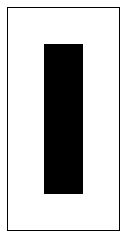

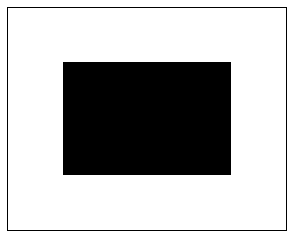

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

%matplotlib inline  

def plot_GOL(GameOfLife, file_prefix=None, file_seq_num=1):
    m = GameOfLife.m
    n = GameOfLife.n
    data = GameOfLife.data
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')

    for i,j in data:
        ax.add_patch(patches.Rectangle((i,j), 1,1, color="black"))

    ax.set_xticks([])
    ax.set_yticks([])
    
    if GameOfLife.boundary in ('periodic', 'fixed'):
        plt.xlim(-1, n+1)
        plt.ylim(-1, m+1)
    else:
        (xmin,xmax), (ymin, ymax) = GameOfLife.get_xylim()
        plt.xlim(xmin-1, xmax+2)
        plt.ylim(ymin-1, ymax+2)
        
    if not file_prefix:
        plt.show()
    else:
        plt.savefig(file_prefix + '-' + str(file_seq_num).zfill(4) + '.png', bbox_inches='tight')
        plt.close(fig)


gol = GameOfLife(data=[[1,1,1,1]], boundary='infinite')
plot_GOL(gol)
plot_GOL(gol.next())
plot_GOL(gol, file_prefix="example", file_seq_num=1)
plot_GOL(gol, file_prefix="example", file_seq_num=2)

In [30]:
import glob
from PIL import Image
from images2gif import writeGif

def animate_GOL(input_file_prefix, output_file="GOL.gif"):
    # read images from current directory
    pattern = input_file_prefix+"*.png"
    images = [Image.open(image) for image in glob.glob(pattern)]
    
    # resize all images to the size of the first image 
    # not perfect for infinite boundary condition)
    size = images[0].size
    for im in images:
        im.thumbnail(size, Image.ANTIALIAS)
    
    # write gif and display
    writeGif(output_file, images, duration=0.4)

animate_GOL("example", output_file="ex.gif")

## Simulation

Now we can run some simulations. While the GOL can update itself infinitely, the simulations most often stablizes in a few stable patterns. We need an algorithm to stop the run. For this, we can count the number of live cells for each generation first. If there are no changes for k generations, the simulation will stop.

In [31]:
from collections import Counter

def run_simulation(game, max_cycle=50):
    results = []
    lives = []
    for i in range(max_cycle):
        lives.append(game.next().n_alive())
        results.append(game)
        plot_GOL(game, file_prefix="square-", file_seq_num=i)
        # if the n_alive does not change for the 10 latest generation, stop
        if len(lives) >= 10 and len(Counter(lives[-10:])) == 1:
            break

    return results

# run simulation
gol_fixed = GameOfLife(m=40, n=40, percent_alive=1, seed=5, boundary='infinite')
results = run_simulation(gol_fixed, max_cycle=100)
print len(results)

# prepare animation
animate_GOL("square-", output_file="square-anim.gif")

import IPython.display as IPdisplay

IPdisplay.Image(url="square-anim.gif")

78
